# スパース回帰のための学習アルゴリズム

多くの（機械）学習課題では、多数の特徴量の候補はあっても、実際に予測や識別等に必要なのはごく少数である。しかし、事前にはどの候補が良いかは当然わからない。そのため、学習時には、データに応じて必要最低限の特徴量だけを選択し、残りを切り捨てて、スパースなモデルを定める必要がある（日本語では「疎」、密の対義語）。

__目次：__

- <a href="#background">スパース推定の背景</a>
- <a href="#coorddesc">2乗誤差を使っての座標降下法</a>
- <a href="#robust">頑健なスパース推定</a>
___

前の回では学習アルゴリズムを実装するための原型らしきものを学んだので、ここではそれを踏まえて、学習結果が一定のスパース性を有するための工夫を学ぶ。

<a id="background"></a>
## スパース推定の背景

Tibshirani氏の1996年の名著を引用すると、多数のパラメータがあるとき（特に標本数よりも多い場合）、スパースな推定結果を求めるべきだ、という理由が2つある。一つは予測精度：

> *"[Naive estimates] often have low bias but large variance; prediction accuracy can sometimes be improved by shrinking or setting to 0 some coefficients."*

もう一つは解釈：

> *"With a large number of predictors, we often would like to determine a smaller subset that exhibits the strongest effects."*

実際、人の脳でも似たような原理が見られる。感覚器を通じて途轍もなく複雑な刺激を常に受けていることは事実だが、その刺激全体を脳全体で処理しているというよりは、刺激の特性によって「分担」している模様である。脳の細部まで調べると、特定の領域が活発に反応するのは、かなり特異的な刺激のみである。普段受けている刺激を多数の特徴量の組み合わせと見なすと、脳がどう反応するか予測するために必要なのはまさしくスパースなモデルである。（画像はHaxby et al., 2001より）

<img src="img/fmri_response.jpg" alt="Image source: Haxby et al. (2001)" width="480"/>

統計的な推論を行なう機械となると、入力が多数あるのだが、設計者が一定の「選択性」を持たせないと結果がスパースにはならない。

<img src="img/sparse_matrix.png" alt="Image: Sparse matrix image" width="240"/>

モデルによるところもあるのだが、基本的には、一つの特徴量の影響が実数値パラメータによって決まると思ってよく、その値をゼロにすることでその影響が無くなるケースがほとんど。よって、多くの場合は、制御するパラメータ$w \in \mathbb{R}^{d}$の要素の大半が零でありながら、それがスパースであるといえる。あとはスパースにさせた結果が高い汎化能力を持つかどうかだ。スパース性をダイレクトに測る場合は、$\ell_{0}$ノルムを使う：

\begin{align}
\|w\|_{0} = \left|\{j \in [d]: w_{j} \neq 0\}\right|.
\end{align}

よって、リスク最小化という文脈でいうと、リスクを$R(w) = \mathbf{E}_{Z} l(w;z)$としたとき、真の目的関数は下記の通り：

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad \text{s.t. } \|w\|_{0} \leq \gamma_{0}.
\end{align}

期待値は近似できるのだが、この制約を満たしながら最小化することは困難である。幸いにも、$\ell_{0}$ノルムを小さくすることは、$\ell_{1}$ノルムを小さくすることで実現できることは、多くの文献からわかってきている。この知見を踏まえて制約を変更すると、

\begin{align}
\min_{w \in \mathbb{R}^{d}} R(w), \quad \text{s.t. } \|w\|_{1} \leq \gamma_{1}
\end{align}

というもう少し攻めやすい問題設定になる。この制約付き最適化は、次の目的関数を用いることで近似できる。

\begin{align}
L_{\lambda}(w) = \frac{1}{n}\sum_{i=1}^{n} l(w;z_{i}) + \lambda \sum_{j=1}^{d}|w_{j}|.
\end{align}

この式を出発点として、有用な学習則をここから丁寧に見ていくことにする。
___

<a id="coorddesc"></a>
## 2乗誤差を使っての座標降下法

具体例から始めると説明しやすいので、典型例として、線形モデルの下で2乗誤差をロス関数とする状況を考える：

\begin{align}
l(w;z) = (y-w^{T}x)^{2}, \quad z=(x,y) \in \mathbb{R}^{d+1}.
\end{align}

このとき、先ほどの目的関数が下記のような形を取る。

\begin{align}
L_{\lambda}(w) = \frac{1}{n} \sum_{i=1}^{n} (y_{i}-w^{T}x_{i})^{2} + \lambda\|w\|_{1}.
\end{align}

難しいのは、絶対値を取っているので微分できない場合がある（パラメータの要素が一つでもゼロになる場合）。すべてのパラメータを一気に更新することは困難なので、愚直で速い方策として、「座標軸ごとに更新をすれば良い」という座標降下法（coordinate descent）がある。一次元ずつだと、更新が簡単になるというメリットがある。

もちろん、

更新則をこれから導出していく。
任意の局所解について、その$j$個目の要素

データと他のパラメータをすべて一定として、$j$個目の座標軸にについて、局所解といえる場合は当然2通りしかなく、$w_j = 0$か$w_j \neq 0$の2つである。

まず、仮に$w$が局所解であるとする。このパラメータベクトルの$j$個目の要素は当然、零か非零のどれかである。事実として、$w_j = 0$であるならば、

\begin{align}
\left| \left.\frac{\partial L_{0}(w)}{\partial w_j}\right|_{w_j = 0} \right| \leq \lambda
\end{align}

が成り立つことはわかっている。ここで示している$L_{0}(\cdot)$とは、$\ell_{1}$の項がない、制約無しの目的関数である。逆に、$w_j = 0$の場合にこの不等式が成り立たないのであれば、$w$が局所解でなくなる。

$w_j \neq 0$ならばどうだろうか。このときは$w_j$について偏微分は求められる：

\begin{align}
\left.\frac{\partial L_{\lambda}(w)}{\partial w_j}\right|_{w_j \neq 0} = 0 \iff \frac{w_{j}}{n}\sum_{i=1}^{n}x_{i,j}^{2} + \lambda \, \text{sign}(w_j) = \frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j}
\end{align}

式を整理するために、

\begin{align}
V_{j} = \frac{1}{n}\sum_{i=1}^{n}x_{i,j}^{2}
\end{align}

と置くと、偏微分がゼロになるための条件は、

\begin{align}
w_{j} = \frac{1}{n \, V_{j}}\sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j} - \frac{\lambda \, \text{sign}(w_j)}{V_{j}}
\end{align}

となる。左辺にも右辺にも$w_{j}$はあるが、明示的に解を求めることはできる:

\begin{align}
w_{j} = \frac{1}{V_{j}} S(\widetilde{g}_{j};\lambda)
\end{align}

ここで使っている関数は

\begin{align}
S(u;\gamma) = \text{sign}\,(u)\max\,(|u|-\gamma, 0)
\end{align}

と定義し、またその入力は

\begin{align}
\widetilde{g}_{j} = \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-\sum_{l \neq j} w_{l}x_{i,l}\right)x_{i,j} = -\left.\frac{\partial L_{0}(w)}{\partial w_j}\right|_{w_j = 0}.
\end{align}

と表記している。少し噛みしめてもらうと、この更新式では$w_{j}$がゼロになるのは、最初の条件として示した不等式が成り立つ場合のみである。

最後に計算する上で重要な点であるが、もし入力データが平均ゼロ、分散1.0と標準化されているのであれば、先ほどの$V_{j}$はすぐに計算できる。まず、$V_{j}$とサンプル分散の関係は

\begin{align}
V_{j} = \frac{n-1}{n} \text{var}\,\left\{x_{1,j},\ldots,x_{n,j}\right\},
\end{align}

となっているので、標準偏差が1.0であれば、各$j = 1,\ldots,d$に対して、$V_{j}=(n-1)/n$とする。

前の回のアルゴリズムクラスを踏まえて、少し改造するだけで上記のアルゴリズムは実装できる。まずはsoft threshold関数を用意する。

In [8]:
import numpy as np

def soft_thres(u,mar):
    '''
    The so-called "soft threshold" function, as made
    popular by the LASSO model and all related
    learning procedures.

    Input "u" will be an array, and "mar" will be the
    margin of the soft-threshold, a non-negative real
    value.
    '''
    
    return np.sign(u) * np.clip(a=(np.abs(u)-mar), a_min=0, a_max=None)


この`soft_thres`は上記の$S$に対応し、`soft_thres(u,mar)`の返す値は$S(u;\gamma)$である。

後はイテレータを用意するだけである。

In [9]:

class Algo_LASSO_CD:

    '''
    Coordinate descent (CD) implementation for minimization
    of the "LASSO" objective, namely the sum of squared errors
    regularized by an l1 penalty.
    '''

    def __init__(self, w_init, t_max, lam_l1, verbose):

        # Store the user-supplied information.
        self.w = np.copy(w_init)
        self.t = 0
        self.t_max = t_max
        self.idxj = 0
        self.lam_l1 = lam_l1
        self.verbose = verbose
    
    
    def __iter__(self):

        # Shuffle up the indices before starting.
        self.idx = np.random.choice(self.w.size, size=self.w.size, replace=False)
        self.idxj = self.idx[0]
        
        if self.verbose:
            print("(via __iter__)")
            self.print_state()
        
        return self
    
    
    def __next__(self):

        # Condition for stopping.
        if self.t >= self.t_max:
            if self.verbose:
                print("--- Condition reached! ---")
            raise StopIteration

        self.t += 1

        if self.verbose:
            print("(via __next__)")
            self.print_state()
    
            
    def update(self, model):
        
        modidx = (self.t-1) % self.w.size
        self.idxj = self.idx[modidx] # circuits around shuffled coords.
    
        self.w[self.idxj] = 0 # current para, but with jth coord set to zero.
        
        g_j = -np.mean(model.g_j_tr(j=self.idxj, w=self.w, lam_l1=0)) * model.n / (model.n-1)
        
        # Compute the solution to the one-dimensional optimization,
        # using it to update the parameters.
        self.w[self.idxj] = soft_thres(u=g_j, mar=self.lam_l1)
        
        
    def print_state(self):
        print("------------")
        print("t =", self.t, "( max = ", self.t_max, ")")
        print("Index is j =", self.idxj)
        print("w = ", self.w)
        print("------------")




基本的な造りは以前に見た`Algo_GD`やその仲間とほぼ同じである。ここもう一度、対応関係を整理した表を出しておこう。

| `code` | 数式で表わした場合 |
| ------ | :----------------: |
| `lam_l1` | $\lambda$ |
| `idx` | $\{1,2,\ldots,d\}$を並べ替えた |
| `idxj` | 更新する座標軸$j \in \{1,\ldots,d\}$ |
| `model.n` | $n$ |
| `g_j` | $\widetilde{g}_{j}$ |

当然のことだが、`t_max`がパラメータの数よりも大きいことが普通である（反復して何度も更新する必要があるため）。上記のアルゴリズムからわかるように、そのときにはただインデックスの先頭に戻って、もう一度すべての座標を見ていく。これができるのは、`modidx`で剰余演算をしているからだ。その振る舞いを列挙しておくと、

\begin{align}
0,1,\ldots,d-1, 0, 1, \ldots, d-1, 0, 1, \ldots
\end{align}

と`t`が`t_max`になるまで繰り返す。ほかのアルゴリズムを実装したときにも述べたが、`model`は抽象化したままである。その詳細について考える必要は今なく、ただ実行時に偏微分を計算してくれる何らかのモデルが用意されていれば良い。

ここからはその挙動を擬似データを通じて、調べていく。例に倣って、データのほうをまず初期化する。

In [10]:
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

# Data information used to initialize the model.
data_info = dp.NoisyOpt_SmallSparse()

print("Data information:")
print(data_info)

Data information:
X_tr: {'shape': (100, 31), 'path': 'data/NoisyOpt_SmallSparse/X_tr.dat', 'dtype': dtype('float64')}
X_te: None
y_tr: {'shape': (100, 1), 'path': 'data/NoisyOpt_SmallSparse/y_tr.dat', 'dtype': dtype('float64')}
y_te: None
mname: NoisyOpt
misc: {'sigma_noise': 2.5, 'cov_X': array([[ 1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85],
       [ 0.85,  1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85],
       [ 0.85,  0.85,  1.  ,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,
         0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.85,  0.

このオブジェクトの属性を見ればわかるように、「真」のパラメータベクトルが毎回変わる。これは毎回ランダムに真のパラメータが決まるようにしているからである。そのdocstringを読んでもらうとその生成過程がわかる：

In [11]:
print("Info on this data:")
print(dp.NoisyOpt_SmallSparse.__doc__)

Info on this data:

    A small simulated data set based on a linear regression model
    with additive noise and a sparse underlying model vector. This
    comes from the Elements of Statistical Learning (ESL2) text,
    in Figure 3.6 on page 59 (with n=300), and again (with n=100)
    on page 78 in Figure 3.16.

    NOTE: since most of the methods we shall be using involve a
    centering and standardizing of the data, we elect to do this
    here, at the time of generation. That is, the sample given
    has EMPIRICAL mean of zero and EMPIRICAL variance of one.
    


次はモデルオブジェクトを用意することである。

In [12]:

mod = mp.model(data_info) # pass the data info.
print("Model information:")
print(mod)
print("checksum:", np.sum(mod.X_tr)) # if re-run everything, data will change.

print("Attributes of the model:")
pp.pprint(dir(mod))


Model information:
MODEL: NoisyOpt.
Info on data as follows...
X_tr:(100, 31)
X_te:None
y_tr:(100, 1)
y_te:None

checksum: -5.68434188608e-14
Attributes of the model:
['X_te',
 'X_tr',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cov_X',
 'd',
 'eval',
 'eval2D_helper',
 'evalDist',
 'evalSparsity',
 'g_imp',
 'g_j_imp',
 'g_j_tr',
 'g_tr',
 'l_imp',
 'l_tr',
 'n',
 'nsub',
 'sigma_noise',
 'w_init',
 'w_initialize',
 'w_true',
 'y_te',
 'y_tr']


使っているモデルは、前の回とまったく同じ`NoisyOpt`である。ここで違うのは、`g_tr`ではなく、`g_j_tr`を使っていることである。前者がすべての座標軸の偏微分を求めるのに対して、後者は指定された＄ｊ$個目の偏微分だけを求めるようになっている。評価指標として、検証データは不要で、`evalDist`を使って真のベクトルからの距離を測るのである。

In [13]:

# Initial point is set by the model (passed via data_info).
w_init = mod.w_initialize()

# Initialize the algorithm object.
al = Algo_LASSO_CD(w_init=w_init,\
                   t_max=10*w_init.size,\
                   lam_l1=0.1,\
                   verbose=False)

al.print_state()


------------
t = 0 ( max =  310 )
Index is j = 0
w =  [[ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.73488504]
 [ 2.91109835]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 3.99578165]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 1.48632723]
 [ 2.11843715]
 [ 2.5       ]
 [ 2.19918763]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.18625277]
 [ 3.1297356 ]
 [ 2.58440407]
 [ 2.5       ]
 [ 2.5       ]
 [ 2.18688371]]
------------


後は、アルゴリズムを実行していくのみ。

In [14]:

for mystep in al:
    al.update(model=mod)
    
w_est = al.w
print("Check the current estimate after completion.")
print(w_est)


Check the current estimate after completion.
[[ -8.49834198e+00]
 [ -2.48276295e-02]
 [  3.77968007e+00]
 [  3.24237611e-01]
 [  3.85857687e+00]
 [ -2.98725222e+00]
 [  6.74816143e+00]
 [  3.39054560e+00]
 [  1.89005498e+00]
 [  3.90723597e-02]
 [  2.40471979e+00]
 [ -5.08787384e-01]
 [  3.65341799e-01]
 [ -2.51992911e+01]
 [ -0.00000000e+00]
 [  6.14331005e+00]
 [  4.38807216e+00]
 [  4.69706985e+00]
 [  5.87690686e+00]
 [  1.65983903e+00]
 [  9.34484127e-01]
 [  4.69993552e+00]
 [  4.05596176e+00]
 [ -0.00000000e+00]
 [ -5.37185372e+00]
 [  1.02173167e+00]
 [  4.11861712e+00]
 [  7.13887162e-01]
 [ -1.59561199e+01]
 [  8.03120193e+00]
 [ -1.13791352e+01]]


### 練習問題 (A):

0. 先ほどの実験で使う$\lambda$パラメータを調整して、その影響を調べること。コードでいうと、`Algo_LASSO_CD`に渡す`lam_l1`の値を変えることである。まずは小さな値、たとえば$\lambda=0.01$ほどから始めて、段々と$\lambda=5$のような大きな値まで試してみること。学習結果（最終ステップにおける`w`）がどのように変わるか。

0. $\lambda$の値と、$\ell_{1}$制約の度合いとの間に、どのような関係があるか。
___

データを持っている時点でも、また$\ell_{1}$のちょうど良い制約がわかっていても、$\lambda$をどう設定すれば良いかは自明ではない。そのため、普通のやり方としては、$\lambda$の候補をたくさん用意し、全部に対して上記のアルゴリズムを実行し、一番良いほうを選ぶ、という流れで学習を進めていく。一つの利点としては、多数の$\lambda$候補を試すと、学習結果を再利用することができるのである。最初はおそらく恣意的に決める初期値であるが、そのあとは段々ともっともらしい解を初期値として使える、warm startの効果が働く。

これを実装することは単純である。`todo_lambda`で$\lambda$の候補を用意し、アルゴリズムを一通り実行したあと、`w_init`に学習結果`w_est`を代入するだけである：

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import math
import support.parse_data as dp
import support.parse_model as mp
import pprint as pp

import numpy as np

todo_lambda = np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150)

dist_overlam = np.zeros(todo_lambda.size) # store performance stats for each lambda setting.
spar_overlam = np.zeros(todo_lambda.size)

data_info = dp.NoisyOpt_SmallSparse()
mod = mp.model(data_info)
w_init = mod.w_initialize()

# Iterate over the lambda values once, for a single candidate.
print("Working...")
for i in range(todo_lambda.size):
    
    # Initialize and execute the algorithm.
    al = Algo_LASSO_CD(w_init=w_init,\
                       t_max=20*w_init.size,\
                       lam_l1=todo_lambda[i],\
                       verbose=False)
    for mystep in al:
        al.update(model=mod)
    
    # Check performance.
    w_est = al.w
    dist_overlam[i] = mod.evalDist(w_est)
    spar_overlam[i] = mod.evalSparsity(w_est)
    
    # Update the initializer to the current estimate.
    w_init = w_est

print("Done.")

Working...
Done.


学習機の性能が$\lambda$の値によってどのような影響を受けるか調べてみよう。

1.48082862682


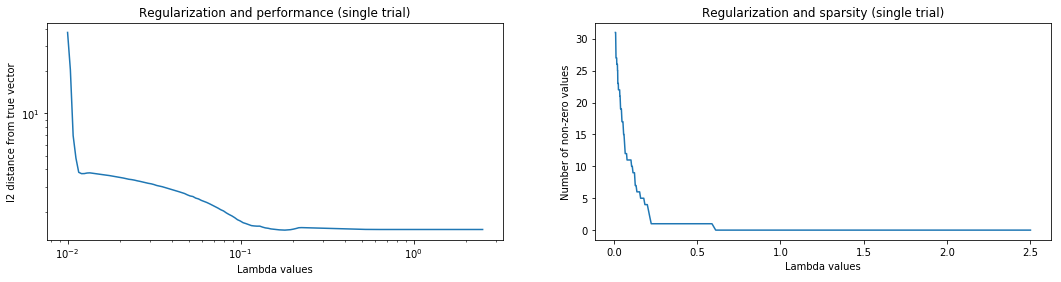

In [18]:

myfig = plt.figure(figsize=(18,4))
ax_dist = myfig.add_subplot(1, 2, 1)
plt.ylabel("l2 distance from true vector")
plt.xlabel("Lambda values")
plt.title("Regularization and performance (single trial)")
ax_dist.set_yscale('log')
ax_dist.set_xscale('log')

ax_spar = myfig.add_subplot(1, 2, 2)
plt.ylabel("Number of non-zero values")
plt.xlabel("Lambda values")
plt.title("Regularization and sparsity (single trial)")

ax_dist.plot(todo_lambda, dist_overlam)
ax_spar.plot(todo_lambda, spar_overlam)
print(np.min(dist_overlam))
plt.show()

注目すべき点：

- より大きな$\lambda$にすると、よりスパースな推定結果が得られることは明らか。要するに$\ell_{1}$（および$\ell_{0}$）の制約が厳しくなってくる。

- 明確な__バイアス__と__バリアンス__（分散）のトレードオフが先の例で見られる。制約設定が厳しすぎると、最適解がそれを満たさない可能性があって、最初から的外れになってしまう（バイアスを食らう）。一方、制約が緩すぎるのもだめで、標本が限られているなかで決めないといけないパラメータ数が多くなると解が定まらず、サンプルごとの分散が甚だ大きくなってしまう。

### 練習問題 (B):

0. 上の例では、小さい$\lambda$から始まり、大きい$\lambda$で終わるようにしている。この大小を逆にしてみてください（大きい値から始まるように）。最高の成績水準が変わるか。それを実現する$\lambda$の値が、大小・小大の順番によって変わるか。

0. 先ほどのwarm startsをやめて、すべての$\lambda$に対してまったく同じ初期値（固定された`w_init`）を使って実行してみること。最高の成績水準が変わるか。また、それを実現する$\lambda$の値が変わるか。

0. 候補としての$(\lambda_{0},\ldots,\lambda_{k})$を決める著名な方法として、対数スケールで一定の間隔にする。つまり、$\log\lambda_{i} - \log\lambda_{i-1} = c > 0$で、この定数$c$はすべての$i$に対して共通している。あとは最大値と最小値を決めることだが、標準的な値は次の通りである（Bühlmann, and Van De Geer, 2011）。データの表記方法として、$y=(y_{1},\ldots,y_{n})$で応答を表わし、$x_{(j)}$で入力行列の$j$番目の列を表わす（$x_{(j)} = (x_{1,j},\ldots,x_{n,j})$）。この表記を使って、最大値と最小値の設定は
<br><br>
\begin{align}
\lambda_{0} = 1/n, \quad \lambda_{k} = \max \left\{|\langle y, x_{(j)}\rangle|/n:j=1,\ldots,d \right\}.
\end{align}
<br>
となる。自分で実装し、有効性を検証すること。

___

上の実行例ではサンプルが一つだけだったが、独立に行なう複数の試行を重ねて、平均的な動きを調べたほうが傾向がわかりやすい。

In [10]:

todo_lambda = np.flipud(np.logspace(start=math.log10(1/100), stop=math.log10(2.5), num=150))
num_lambda = todo_lambda.size
num_trials = 10

dist_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))
spar_overtrials = np.zeros(num_lambda*num_trials, dtype=np.float64).reshape((num_trials, num_lambda))

dist_overlam = np.zeros(todo_lambda.size, dtype=np.float64) # store performance stats for each lambda setting.
spar_overlam = np.zeros(todo_lambda.size, dtype=np.float64)

for tr in range(num_trials):

    data_info = dp.NoisyOpt_SmallSparse()
    mod = mp.model(data_info)
    w_init = mod.w_initialize()

    # Iterate over the lambda values once, for a single candidate.
    print("Trial number", tr, "... Working.")
    for i in range(todo_lambda.size):
    
        # Initialize and execute the algorithm.
        al = Algo_LASSO_CD(w_init=w_init,\
                           t_max=20*w_init.size,\
                           lam_l1=todo_lambda[i],\
                           verbose=False)
        for mystep in al:
            al.update(model=mod)
    
        # Check performance.
        w_est = al.w

        dist_overlam[i] = mod.evalDist(w_est)
        spar_overlam[i] = mod.evalSparsity(w_est)
    
        # Update the initializer to the most current observation.
        w_init = w_est
    
    dist_overtrials[tr,:] = dist_overlam
    spar_overtrials[tr,:] = spar_overlam
    
dist_ave = np.mean(dist_overtrials, axis=0)
dist_sd = np.std(dist_overtrials, axis=0)
spar_ave = np.mean(spar_overtrials, axis=0)
spar_sd = np.std(dist_overtrials, axis=0)

dist_argmin = todo_lambda[np.argmin(dist_ave)] # lambda realizing smallest distance.

print("Done.")

Trial number 0 ... Working.
Trial number 1 ... Working.
Trial number 2 ... Working.
Trial number 3 ... Working.
Trial number 4 ... Working.
Trial number 5 ... Working.
Trial number 6 ... Working.
Trial number 7 ... Working.
Trial number 8 ... Working.
Trial number 9 ... Working.
Done.


複数トライアルを実行した結果を可視化してみよう。

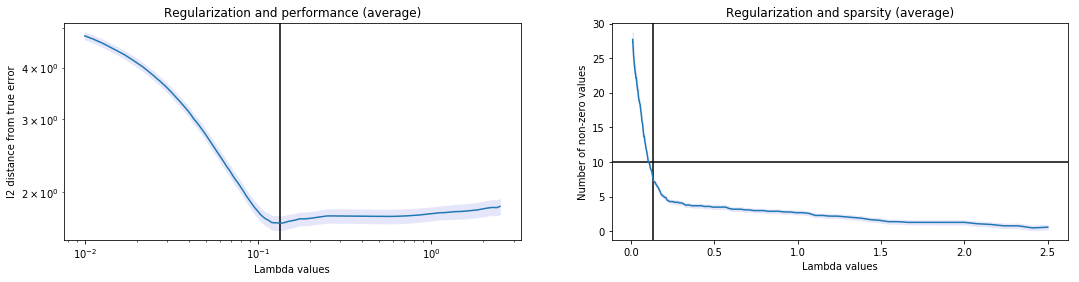

In [11]:
myfig = plt.figure(figsize=(18,4))

ax_dist = myfig.add_subplot(1, 2, 1)
plt.ylabel("l2 distance from true error")
plt.xlabel("Lambda values")
plt.title("Regularization and performance (average)")
ax_dist.set_yscale('log')
ax_dist.set_xscale('log')
plt.axvline(x=dist_argmin, color="black")

logerr = dist_sd / (math.log(10)*dist_ave) # for error bars when using log scale
plt.fill_between(todo_lambda, dist_ave-logerr,  
                 dist_ave+logerr, color="lavender")
ax_dist.plot(todo_lambda, dist_ave)

ax_spar = myfig.add_subplot(1, 2, 2)
plt.ylabel("Number of non-zero values")
plt.xlabel("Lambda values")
plt.title("Regularization and sparsity (average)")
plt.axvline(x=dist_argmin, color="black")
plt.axhline(y=10, color="black")

err = spar_sd # for error bars in original scale
plt.fill_between(todo_lambda, spar_ave-err,  
                 spar_ave+err, color="lavender")
ax_spar.plot(todo_lambda, spar_ave)

plt.show()

全体的な傾向として、最も良いパフォーマンスが出るのは、正しいスパース性をもたらす$\lambda$に設定したときである。擬似データの生成も、アルゴリズム自体の働きも、おそらく正常であろうということがわかる。

### 練習問題 (C):

0. 全パラメータを何周するかによって、学習結果がどの程度変わるか。極端に少ない（各要素を一度だけ更新する）場合と、何度も更新する場合、それぞれを試して比較すること。

0. 前の練習問題と同様に、warm startsをやめて、$\lambda$候補をすべて同一の初期値を使って検証すること。試行を重ねて、パフォーマンスの平均・分散、スパース性の平均・分散を調べて、warm startsありと場合と比較してみること。

0. 試行ごとに、もっとも良い成績を残した$\lambda$の値を記録するようにコードを改造すること。これらの値の平均と分散はどうか。サンプルのばらつきに対して、もっとも良い$\lambda$の値が敏感に思われるか。

0. （おまけ）次の属性を`Algo_LASSO_CD`に追加してください：`w_old`、`thres`、`diff`の3つである。`w.size`（つまり$d$）回の更新をするごとに、`diff`に`w`と`w_old`の距離を代入してから、`w_old`に`w`を代入する。新たな終了条件をここで追加：`diff`が閾値`thres`を下回ると、直ちに終了する。

0. （おまけ）先の問題の続きだが、`thres`を使った終了条件では、だいたい何周すれば収束するか。また、この収束速度が$\lambda$の値にどう依存するか。

0. （おまけ）何周もするなら、多くの$w_{j}$がずっとゼロである。それにもかかわらず、毎回同じ更新式のための計算はするので、無駄な計算として省ける。すべてのパラメータを何度も見るのではなく、パラメータが一旦ゼロになると二度と更新しない（`idx`のなかから削除する）、という方策も有名である。これを実装し、成績を調べること。通常のやり方と比較し、性能がどう変わるか。計算時間はどうか。
___

<a id="robust"></a>
## 頑健なスパース推定

建設中．

### 終わり： 後に使う関数などを`scripts/AlgoSparseReg.py`に貼り付けること。

## 参考文献：

- Bühlmann, Peter, and Sara Van De Geer. Statistics for high-dimensional data: methods, theory and applications. Springer Science & Business Media, 2011.
- Haxby, James V., et al. "Distributed and overlapping representations of faces and objects in ventral temporal cortex." Science 293.5539 (2001): 2425-2430.